In [ ]:
!pip3 install datasets transformers

In [6]:
import torch
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
import numpy as np
from datasets import load_metric
from transformers import TrainingArguments, Trainer
import pandas as pd

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pyarrow as pa
from datasets import Dataset
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
from sklearn.utils import shuffle
from datasets import Dataset, Value, ClassLabel, Features

In [8]:
torch.cuda.is_available()

True

**Download From Kaggle Dataset**

In [26]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"<username>","key":"<api_key>"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json
     

In [27]:
!kaggle datasets download -d kritanjalijain/amazon-reviews

 99% 1.28G/1.29G [00:05<00:00, 251MB/s]
100% 1.29G/1.29G [00:05<00:00, 244MB/s]


In [28]:
!unzip amazon-reviews

Archive:  amazon-reviews.zip
  inflating: amazon_review_polarity_csv.tgz  
  inflating: test.csv                
  inflating: train.csv               


In [83]:
df_train = pd.read_csv("train.csv",index_col=False)
df_test = pd.read_csv("test.csv",index_col=False)
df_train.columns =['label','title','summary']
df_test.columns =['label','title','summary']

**Merge title with summary**

In [84]:
df_train["text"] = df_train["title"] + df_train["summary"]
df_test["text"] = df_test["title"] + df_test["summary"]

df_train = df_train.drop(columns=['title', 'summary'])
df_test = df_test.drop(columns=['title', 'summary'])

df_train = df_train[["text","label"]]
df_test = df_test[["text","label"]]

In [7]:
df_train.head()

,text,label
0,The best soundtrack ever to anything.I'm readi...,2
1,Amazing!This soundtrack is my favorite music o...,2
2,Excellent SoundtrackI truly like this soundtra...,2
3,"Remember, Pull Your Jaw Off The Floor After He...",2
4,an absolute masterpieceI am quite sure any of ...,2


In [8]:
df_test.head()

,text,label
0,One of the best game music soundtracks - for a...,2
1,Batteries died within a year ...I bought this ...,1
2,"works fine, but Maha Energy is betterCheck out...",2
3,Great for the non-audiophileReviewed quite a b...,2
4,DVD Player crapped out after one yearI also be...,1


**Get polarity scores ratio in the train data**

In [9]:
df_train['label'].value_counts()

1    1800000
2    1799999
Name: label, dtype: int64

**Get Word cloud with respect to the data for polarity = 2 which stands for postivie**

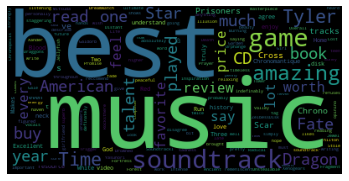

In [13]:
positive =  df_train.loc[df_train['label'] == 2]
text = positive['text'].values 
wordcloud = WordCloud().generate(str(text))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

**Get Word cloud with respect to the data for polarity = 1 which stands for negative**

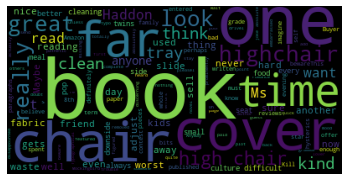

In [14]:
negative =  df_train.loc[df_train['label'] == 1]
text = negative['text'].values 
wordcloud = WordCloud().generate(str(text))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

**Loading the tokenizer**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

**Load the train df to Arrow dataset**

Refer : https://huggingface.co/docs/datasets/v1.0.2/loading_datasets.html


* sampling the df_train to 8000 (Just to train the model quicker)
*   removing none values from the df
*   reset the index and remove the index from the df
*   Convert the df to arrow dataset
*   Change the feature of the dataset

The tokenized_text must have form of


**0 stand for negative and 1 stands for positive**


```
{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['0', '1'], id=None)}
```







In [86]:
def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True,padding=True)

In [87]:
df_train = df_train[:8000]
df_train =  df_train.dropna()
df_train.reset_index(drop=True, inplace=True)

# df_train to arrow dataset
dataset = Dataset.from_pandas(df_train)
print(dataset.features)

# change the feature of the dataset
features = dataset.features.copy()
# 0 stand for negative and 1 stands for positive
features["label"] = ClassLabel(num_classes=2, names=['0','1'])
def adjust_labels(batch):
    batch["label"] = [str(sentiment - 1) for sentiment in batch["label"]]
    return batch
dataset = dataset.map(adjust_labels, batched=True, features=features)

print(dataset.features)
tokenized_train = dataset.map(preprocess_function, batched=True)

{'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None)}


  0%|          | 0/8 [00:00<?, ?ba/s]

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['0', '1'], id=None)}


  0%|          | 0/8 [00:00<?, ?ba/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 8000
})

In [88]:
tokenized_train.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['0', '1'], id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

**Trimming test data to 1000**

In [90]:
df_test = df_test[:1000]
df_test =  df_test.dropna()
df_test.reset_index(drop=True, inplace=True)

# df_test to arrow dataset
dataset = Dataset.from_pandas(df_test)
print(dataset.features)

# change the feature of the dataset
features = dataset.features.copy()
# 0 stand for negative and 1 stands for positive
features["label"] = ClassLabel(num_classes=2, names=['0','1'])
def adjust_labels(batch):
    batch["label"] = [str(sentiment - 1) for sentiment in batch["label"]]
    return batch
dataset = dataset.map(adjust_labels, batched=True, features=features)

tokenized_test = dataset.map(preprocess_function, batched=True)

{'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None)}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [91]:
tokenized_train.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['0', '1'], id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

**To speed up training, let's use a data_collator to convert your training samples to PyTorch tensors and concatenate them with the correct amount of padding**

In [92]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# **Define a Model**

DistilBERT is a small, fast, cheap and light Transformer model based on the BERT architecture. 

Knowledge distillation is performed during the pre-training phase to reduce the size of a BERT model by 40%.

https://www.techtarget.com/searchenterpriseai/definition/BERT-language-model

distilbert-base-uncased

https://huggingface.co/distilbert-base-uncased



In [93]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when in

In [94]:

def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")
  
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy, "f1": f1}


training_args = TrainingArguments(
   output_dir="/content/model/",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=2,
   weight_decay=0.01,
   save_strategy="epoch",
   push_to_hub=False,
)
 

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)
     

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [95]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 8000
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1000
  Number of trainable parameters = 66955010
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster t

Step,Training Loss
500,0.291600
1000,0.143400


Saving model checkpoint to /content/model/checkpoint-500
Configuration saved in /content/model/checkpoint-500/config.json
Model weights saved in /content/model/checkpoint-500/pytorch_model.bin
tokenizer config file saved in /content/model/checkpoint-500/tokenizer_config.json
Special tokens file saved in /content/model/checkpoint-500/special_tokens_map.json
Saving model checkpoint to /content/model/checkpoint-1000
Configuration saved in /content/model/checkpoint-1000/config.json
Model weights saved in /content/model/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in /content/model/checkpoint-1000/tokenizer_config.json
Special tokens file saved in /content/model/checkpoint-1000/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1000, training_loss=0.2174837417602539, metrics={'train_runtime': 502.3248, 'train_samples_per_second': 31.852, 'train_steps_per_second': 1.991, 'total_flos': 1506953266716864.0, 'train_loss': 0.2174837417602539, 'epoch': 2.0})

In [96]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16


<ipython-input-94-c8349362e4dc>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")


{'eval_loss': 0.22935445606708527,
 'eval_accuracy': 0.927,
 'eval_f1': 0.9283611383709519,
 'eval_runtime': 8.9558,
 'eval_samples_per_second': 111.659,
 'eval_steps_per_second': 7.035,
 'epoch': 2.0}

In [98]:
trainer.save_model("/content/trained_model/")

Saving model checkpoint to /content/trained_model/
Configuration saved in /content/trained_model/config.json
Model weights saved in /content/trained_model/pytorch_model.bin
tokenizer config file saved in /content/trained_model/tokenizer_config.json
Special tokens file saved in /content/trained_model/special_tokens_map.json


In [105]:
!zip -r trained.zip /content/trained_model/

  adding: content/trained_model/ (stored 0%)
  adding: content/trained_model/vocab.txt (deflated 53%)
  adding: content/trained_model/special_tokens_map.json (deflated 42%)
  adding: content/trained_model/pytorch_model.bin (deflated 8%)
  adding: content/trained_model/tokenizer_config.json (deflated 41%)
  adding: content/trained_model/tokenizer.json (deflated 71%)
  adding: content/trained_model/config.json (deflated 46%)
  adding: content/trained_model/training_args.bin (deflated 48%)


In [108]:
!cp trained.zip /content/drive/MyDrive/amazon/

In [ ]:
from transformers import TextClassificationPipeline

model = AutoModelForSequenceClassification.from_pretrained("/content/trained_model/", num_labels=2)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)

In [101]:
pipe("I just completed reading Whisper of the Evil Saints, a five-star book. I was smitten by the characters. I was looking for a typical romance book, but I ended up finding one of my all-time favourite books. I was stunned right when I believed I could foresee the result! Since the writing was so vivid, I felt as though I was there with the characters rather than just reading about them from a distance when Julia's heart broke. This is a must-read if romance books are your thing. Don't be fooled by the cover—this book is amazing!")
# LABEL_0 = not happy
# LABEL 1 = happy

[[{'label': 'LABEL_0', 'score': 0.006528467871248722},
  {'label': 'LABEL_1', 'score': 0.9934715032577515}]]

In [104]:
pipe("horrible beyond words! To prevent others from squandering their money, I feel compelled to write. This novel appears to have been authored by a seventh-grader who uses inappropriate grammar for her age. There is a mistake on the cover, as another reviewer has noted, and I think there is at least one in each chapter. For instance, she had a 'lean' on her house, which was mentioned twice. I chose to read with a pencil in hand to highlight all of the terrible grammar and spelling because the thin plot and poor writing were so distracting. Please don't throw away your cash. I also think that the author's family members must have written the favourable reviews. I will not put much faith")
# LABEL_0 = not happy
# LABEL 1 = happy

[[{'label': 'LABEL_0', 'score': 0.9949256181716919},
  {'label': 'LABEL_1', 'score': 0.005074410233646631}]]